# CartPole with Deep Sarsa

Environment: [CartPole-v0](https://github.com/openai/gym/wiki/CartPole-v0)

![](https://www.gymlibrary.ml/_images/cart_pole.gif)

## Source Codes

### Library

DRL agent:
* [Deep Sarsa](../rl/drl_agent/deep_sarsa.py)

### Import modules

In [10]:
import sys
import os
sys.path.append(os.pardir)

import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import gym
import rl

rl.util.seed(0)

### Define Q value network

In [11]:
class QValueNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(QValueNet, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim)
        )
        
    def forward(self, x):
        q_val = self.layers(x)
        return q_val

### Create CartPole-v0 environment

In [12]:
try:
    env.close()
except:
    pass

env = gym.make("CartPole-v0", new_step_api=True)

c:\Anaconda3\envs\rl-algorithm\lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "


In [13]:
obs_shape = env.observation_space.shape[0]
action_count = env.action_space.n

print(f"obs_shape: {obs_shape}, action_count: {action_count}")

obs_shape: 4, action_count: 2


### Instantiate Deep Sarsa agent

In [14]:
learning_rate = 0.01
q_value_net = QValueNet(obs_shape, action_count)
optimizer = optim.Adam(q_value_net.parameters(), lr=learning_rate)

In [15]:
gamma = 0.99

deep_sarsa = rl.DeepSarsa(
    q_value_net,
    optimizer,
    action_count,
    epsilon_decay=rl.util.LinearDecay(0.3, 0.05, 15000),
    gamma=gamma
)

### Training

In [16]:
from tqdm import tqdm

episode_count = 8000
max_time_step = 200
rewards_arr = []

for episode in tqdm(range(episode_count)):
    current_state = env.reset(seed=0)
    deep_sarsa.start_episode()
    total_rewards = 0.0
    
    for t in range(max_time_step):
        current_action = deep_sarsa.get_action(current_state[np.newaxis, :])
        current_action = np.squeeze(current_action, 0)
        next_state, reward, terminated, _, _ = env.step(current_action)
        transition = rl.Transition(
            current_state,
            current_action,
            next_state,
            reward,
            terminated
        )
        deep_sarsa.update(transition)
        total_rewards += reward
        #env.render()
        if terminated:
            break
        current_state = next_state
        
    deep_sarsa.end_episode()
    rewards_arr.append(total_rewards)

100%|██████████| 8000/8000 [01:49<00:00, 73.21it/s] 


### Close the environment

In [17]:
env.close()

### Print results

rewards


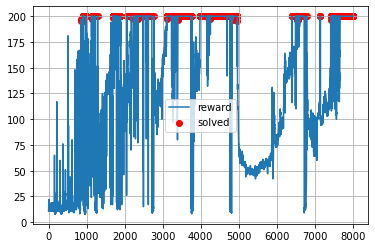

average rewards of last 100 rewards


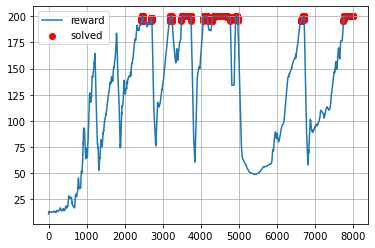

In [18]:
import matplotlib.pyplot as plt

def solved(rewards):
    solved_rewards = 195
    rewards = np.array(rewards)
    solved_pred = rewards >= solved_rewards
    solved_x = np.arange(episode_count)[solved_pred]
    solved_y = rewards[solved_pred]
    return solved_x, solved_y

def plot_rewards(rewards):
    solved_x, solved_y = solved(rewards)
    plt.plot(rewards, label="reward")
    plt.scatter(solved_x, solved_y, c="red", label="solved")
    plt.legend()
    plt.grid()
    plt.show()

print("rewards")
plot_rewards(rewards_arr)

print("average rewards of last 100 rewards")
rewards_arr = rl.util.average_last_data(rewards_arr, 100)
plot_rewards(rewards_arr)